### Load in initial packages

In [59]:
import pandas as pd
import oscn
import nltk
from bs4 import BeautifulSoup
import re
import numpy as np
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
#Uncomment on initial run -- #nltk.download('punkt')
from tqdm import tqdm
from difflib import SequenceMatcher
import pickle

In [60]:
#!pip install sklearn-crfsuite
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
#nltk.download('punkt')
from sklearn.model_selection import KFold, StratifiedKFold

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, TimeDistributed, Bidirectional, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

## Lookup Docket Functions

In [62]:
def lookUpDocket(docNum):
    splitNum = docNum.split('-')
    #print(splitNum)
    docType = splitNum[0]
    year = splitNum[1]
    county ='Tulsa'
    docNum = splitNum[2]
    #print("Split: ", docType, ' ', year, ' ', docNum)
    case=oscn.request.Case(type=docType, year=year,county=county,number=docNum)
    return case

#### Pulling out Judge, defendant lawyer & state rep from given text

Commented out all of the print functions, so the execution of the code below isn't so lengthy

In [63]:
def matchTagPatterns(string, pattern):
    match_list = []
    #print("Pattern is ",pattern)
    pattern = re.sub(r'[^\w\s]','',pattern)
    pattern = pattern.strip()
    #print("Stripped Pattern: ",pattern)
    seqMatch = SequenceMatcher(None, string, pattern, autojunk=False)
    match = seqMatch.find_longest_match(0, len(string), 0, len(pattern))
    if (match.size == len(pattern)):
        start = match.a
        end = match.a + match.size
        match_tup = (start, end)
        string = string.replace(pattern, "X" * len(pattern), 1)
        match_list.append(match_tup)
        
    return match_list, string

def mark_sentence(s, match_list):
    word_dict = {}
    for word in s.split():
        word_dict[word] = 'O'
        
    for start, end, e_type in match_list:
        temp_str = s[start:end]
        tmp_list = temp_str.split()
        if len(tmp_list) > 1:
            word_dict[tmp_list[0]] = 'B-' + e_type
            for w in tmp_list[1:]:
                word_dict[w] = 'I-' + e_type
        else:
            word_dict[temp_str] = 'B-' + e_type
    return word_dict

def clean(text):
    soup = BeautifulSoup(text)
    text = soup.get_text()
    text = re.sub(r'[^\w\s]','',text)
    return text

def create_data(df):
    match_list = []
    for text, annotation in zip(df.text, df.annotation):
        #print("Text : ", text)
        #print("annotation : ", annotation)
        text = clean(text)
        #print("text cleaned")
        text_ = text 
        #print(text_)

        for i in annotation:
            a, text_ = matchTagPatterns(text, i[0])
            #print('a:',a)
            #print('i:',i)
            if a:
                match_list.append((a[0][0], a[0][1], i[1]))
    d = mark_sentence(text, match_list)
    return d

#### Creating tuples and tagging out the keywords we want to identify

This sets up the data into easier to use pairs of `(word, tag)`

In [64]:
def createTuples(i, value, column):
    values = value.split('\n')
    tuples = []
    for val in values:
        tuples.append(tuple((val,column)))
    #print("found tuples ",tuples," for ", value)
    return tuples
#Tuple reference
#https://stackoverflow.com/questions/31175223/append-a-tuple-to-a-list-whats-the-difference-between-two-ways/31175264
def getValues(i,column):
    value = training[column][i]
    tuples = []
    #print("Values ", value, " found ", pd.isnull(value), " is null for column ",column)
    if not(pd.isnull(value)):
        if ('\n' in value):
            tuples = createTuples(i, value, column)
        else:
            tuples.append(tuple([value,column]))
    #print("tuple created ", tuples)
    return tuples
def zipTuples(lst):
    lst_tuple = [x for x in zip(*[iter(lst)]*2)]
    #print(lst_tuple)
    return lst_tuple
def getAnnotations(i, columns):
    annotations = []
    for column in columns:
        tuples = getValues(i,column)
        #print("tuples created =", tuples, " tuples")
        annotations = np.append(annotations,[[tuples]]) 
        #print("annotations created =", annotations, " annotations")
    return zipTuples(annotations)
        
def getTags(case,i):
    #print("This is the ",i,"th case")
    columns = ['Judge','Defendant lawyer','State Rep']
    annotations = getAnnotations(i, columns)
    tags = [[case.text, annotations]]
    return tags

## Features, Tokens, and Label Lists

Features used by the CRF Model, but not the eventual LSTM Neural Network. 

In [65]:
def word2features(sent, i):
    word = sent[i][0]
    #postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:
        word1 = sent[i-1][0]
        #postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        #postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, label in sent]

def sent2tokens(sent):
    return [token for token, label in sent]

In [66]:
def tagsToSent(tags):
    sentList = []
    for i in range(len(tags)):
        #https://www.kite.com/python/answers/how-to-convert-a-dictionary-into-a-list-of-tuples-in-python
        #print(tags[i].items())
        dictItems = tags[i].items()
        sentList.append(list(dictItems))
    return sentList

## Running Dockets through Tagger 

### Pulling in the Training Data

* If you've got the pickled file `taggedNERSet`  and want to see setup for NN, then you can skip to the Word Mapping section
* If you've got the pickled files `X`,`y`,`X_val`,`y_val`, you can skip to the Bidirectional LSTM section where the Neural Network modelling starts

In [67]:
#Load in data
training = pd.read_csv('../../Data/judge_training_labels.csv')
training.head()

,Docket Number,Conviction,NER Training Paragraph,Judge,Defendant lawyer,State Rep,Sentencing,Link,Year
0,CF-2012-5905,Y,JUDGE DAWN MOODY: DEFENDANT PRESENT NOT IN CUS...,DAWN MOODY,SHEILA NAIFEH,JULIANNE BURTON,TWO (2) YEARS,https://www.oscn.net/dockets/GetCaseInformatio...,2012
1,CF-2012-5896,Y,JUDGE JAMES CAPUTO: DEFENDANT PRESENT REPRESEN...,JAMES CAPUTO,DARRELL BOLTON,KALI STRAIN,TWO (2) YEARS DEPARTMENT OF CORRECTIONS,https://www.oscn.net/dockets/GetCaseInformatio...,2012
2,CF-2012-5886,Y,JUDGE JAMES CAPUTO: DEFENDANT PRESENT IN CUSTO...,JAMES CAPUTO,ADAM HASELGREN,KALI STRAIN,THREE (3) YEARS IN DEPARTMENT OF CORRECTIONS,https://www.oscn.net/dockets/GetCaseInformatio...,2012
3,CF-2012-5591,N,JUDGE CLIFFORD SMITH: DEFENDANT PRESENT IN CUS...,CLIFFORD SMITH,CLAY IJAMS,SEAN HILL,STATE DISMISSES,https://www.oscn.net/dockets/GetCaseInformatio...,2012
4,CF-2012-5914,Y,\nJUDGE STEPHEN CLARK: DEFENDANT PRESENT NOT I...,STEPHEN CLARK,CARLOS WILLIAMS,ERIC LOGGIN,FIVE (5) YEAR DEFERRED SENTENCE\nFIVE (5) YEAR...,https://www.oscn.net/dockets/GetCaseInformatio...,2012


In [68]:
#Reviewing the one record to validate
#training.iloc[[n]]

Example of usage of the `lookUpDocket` function using the first row's Docket Number column

In [69]:
#Parse out the Docket number using the above function
#testNum = training['Docket Number'][0]
#case = lookUpDocket(testNum) #training['Docket Number'][0]
#case

Example of usage of the `word_tokenize`

In [70]:
#Return a tokenized copy of text
#tokenizedCase = word_tokenize(case.text)
#tokenizedCase

### Pulling out the Judge, Defendant Lawyer & State Rep from training set

In [71]:
allTags =[]
for i in training.index:
    case = lookUpDocket(training['Docket Number'][i])
    data = pd.DataFrame(getTags(case,i), columns=['text', 'annotation'])
    taggedSet = create_data(data)
    allTags.append(taggedSet)
#allTags[0]

#### Converting a dictionary into a list of tuples

`tagsToSent` takes the given tagged dictionary for each document and turns them into a list form. This `sentList` is now a list of lists that represent a single OSCN document's text: 

`[document1,document2...]`

Sentences are the normal way documents are broken up and tagged. We are treating each OSCN document as a 'sentence' to keep documents together and for ease of assigning the entities to a case number. Each of these documents are made up of tagged word lists in tuple form:

`[('OSCN','O'),...,('JANE', 'B-State Rep'), ('DOE', 'I-State Rep'),...]`

In [72]:
sentList = tagsToSent(allTags)
#sentList[0]

In [73]:
# Pickle tagged data for later runs without invoking the OSCN scraper
file_name = f'taggedNERSet'
f = open(file_name, 'wb')
pickle.dump(sentList, f)
f.close()

In [74]:
#Use pickled data from above tagging
file_name = f'taggedNERSet'
sentList2 = pickle.load(open(file_name, 'rb'))
#testing load to new list to ensure we actually saved and reloaded
#sentList2[0]

## Running against a CRF Model

Just for mechanics sake seeing if we've gotten the data into a state that it can be manipulated by a model (that's why test and train are the same set) Run the above cell that loads processed training data into sentList2

In [75]:
#sentList
X = [sent2tokens(s) for s in sentList2]
y = [sent2labels(s) for s in sentList2]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [76]:
%%time
#X_train = [sent2features(s) for s in sentList2]
#y_train = [sent2labels(s) for s in sentList2]

#test is same as train just for functionality testing
#X_test = [sent2features(s) for s in sentList2]
#y_test = [sent2labels(s) for s in sentList2]

Wall time: 0 ns


In [77]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

Wall time: 3.31 s


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

Looking at just the non-O taggs from the CRF Model

In [78]:
labels = list(crf.classes_)
labels.remove('O')
labels

['B-Judge',
 'B-State Rep',
 'I-State Rep',
 'B-Defendant lawyer',
 'I-Defendant lawyer',
 'I-Judge']

In [79]:
y_pred = crf.predict(X_test)

In [80]:
# group B and I results
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

                    precision    recall  f1-score   support

B-Defendant lawyer      0.600     0.043     0.080        70
I-Defendant lawyer      0.600     0.040     0.075        75
           B-Judge      0.750     0.045     0.086        66
           I-Judge      0.750     0.037     0.071        80
       B-State Rep      0.400     0.029     0.053        70
       I-State Rep      0.400     0.028     0.053        71

         micro avg      0.571     0.037     0.070       432
         macro avg      0.583     0.037     0.070       432
      weighted avg      0.585     0.037     0.070       432



# Word Mapping

Load in the previous run pickle data which includes the 3 key columns to train the model on in the right format 

In [81]:
#Use pickled data from above tagging
file_name = f'taggedNERSet'
sentList2 = pickle.load(open(file_name, 'rb'))

In [82]:
#sentList2[55]

In [83]:
#sentList
X_train = [sent2tokens(s) for s in sentList2]
y_train = [sent2labels(s) for s in sentList2]

#test is same as train just for functionality testing
X_test = [sent2tokens(s) for s in sentList2]
y_test = [sent2labels(s) for s in sentList2]

In [84]:
#X_train[1]

In [85]:
for i in zip(X_train[1],y_train[1]):
    print(i)

('OSCN', 'O')
('Case', 'O')
('Details', 'O')
('Skip', 'O')
('to', 'O')
('Main', 'O')
('Content', 'O')
('Accessibility', 'O')
('Statement', 'O')
('Help', 'O')
('Contact', 'O')
('Us', 'O')
('epayments', 'O')
('Careers', 'O')
('toggle', 'O')
('navigation', 'O')
('Home', 'O')
('Courts', 'O')
('Decisions', 'O')
('Programs', 'O')
('News', 'O')
('Legal', 'O')
('Research', 'O')
('Court', 'O')
('Records', 'O')
('Quick', 'O')
('Links', 'O')
('The', 'O')
('information', 'O')
('on', 'O')
('this', 'O')
('page', 'O')
('is', 'O')
('NOT', 'O')
('an', 'O')
('official', 'O')
('record', 'O')
('Do', 'O')
('not', 'O')
('rely', 'O')
('the', 'O')
('correctness', 'O')
('or', 'O')
('completeness', 'O')
('of', 'O')
('Verify', 'O')
('all', 'O')
('with', 'O')
('keeper', 'O')
('contained', 'O')
('in', 'O')
('report', 'O')
('provided', 'O')
('compliance', 'O')
('Oklahoma', 'O')
('Open', 'O')
('Act', 'O')
('51', 'O')
('OS', 'O')
('24A1', 'O')
('Use', 'O')
('governed', 'O')
('by', 'O')
('act', 'O')
('as', 'O')
('well

In [86]:
from collections import Counter
words = []
for entry in X_train:
    for word in entry:
        words.append(word)

In [87]:
#Unique words counted in the dockets, then mapping the words to a number (which will then be used in the NN)
wc = Counter(words)
len(wc)

15841

In [88]:
word_map = {}
for i,(k,v) in enumerate(wc.most_common()):
    word_map[k] = i+2 #starting sequence after unknowns
word_map['<pad>']=0 #padding values
word_map['<unk>']=1 #unknown values

In [89]:
word_map

{'OSCN': 2,
 'Case': 3,
 'Details': 4,
 'Skip': 5,
 'to': 6,
 'Main': 7,
 'Content': 8,
 'Accessibility': 9,
 'Statement': 10,
 'Help': 11,
 'Contact': 12,
 'Us': 13,
 'epayments': 14,
 'Careers': 15,
 'toggle': 16,
 'navigation': 17,
 'Home': 18,
 'Courts': 19,
 'Decisions': 20,
 'Programs': 21,
 'News': 22,
 'Legal': 23,
 'Research': 24,
 'Court': 25,
 'Records': 26,
 'Quick': 27,
 'Links': 28,
 'The': 29,
 'information': 30,
 'on': 31,
 'this': 32,
 'page': 33,
 'is': 34,
 'NOT': 35,
 'an': 36,
 'official': 37,
 'record': 38,
 'Do': 39,
 'not': 40,
 'rely': 41,
 'the': 42,
 'correctness': 43,
 'or': 44,
 'completeness': 45,
 'of': 46,
 'Verify': 47,
 'all': 48,
 'with': 49,
 'keeper': 50,
 'contained': 51,
 'in': 52,
 'report': 53,
 'provided': 54,
 'compliance': 55,
 'Oklahoma': 56,
 'Open': 57,
 'Act': 58,
 '51': 59,
 'OS': 60,
 '24A1': 61,
 'Use': 62,
 'governed': 63,
 'by': 64,
 'act': 65,
 'as': 66,
 'well': 67,
 'other': 68,
 'applicable': 69,
 'state': 70,
 'and': 71,
 'feder

In [90]:
#Pulling out the tag map that we want to focus on training the data on ( 0 = unknown/pad )
## Does the label/ordering of this map matter?
tags = []
for entry in y_train:
    for tag in entry:
        tags.append(tag)
tags = list(set(tags))

tag_map = {}
for i,v in enumerate(tags):
    tag_map[v] = i+1
    tag_map[0] = 0
    
tag_map

{'I-Defendant lawyer': 1,
 0: 0,
 'B-State Rep': 2,
 'B-Defendant lawyer': 3,
 'I-State Rep': 4,
 'I-Judge': 5,
 'O': 6,
 'B-Judge': 7}

In [91]:
%store tag_map

Stored 'tag_map' (dict)


In [92]:
tag_map

{'I-Defendant lawyer': 1,
 0: 0,
 'B-State Rep': 2,
 'B-Defendant lawyer': 3,
 'I-State Rep': 4,
 'I-Judge': 5,
 'O': 6,
 'B-Judge': 7}

In [93]:
X=[]
y=[]
for sent in X_train:
    X.append([word_map[i] for i in sent])
for seq in y_train:
    y.append([tag_map[i] for i in seq])
X_val = []
y_val = []

#TO DO: Actual Train Test Split
for sent in X_test:
    X_val.append([word_map[i] if i in word_map.keys() else 1 for i in sent])
for seq in y_test:
    y_val.append([tag_map[i] for i in seq])

In [94]:
#This is calling just the index within the wordmap, because NN can only handle numbers
#X[0]

In [95]:
print(max([len(i) for i in X]))

1243


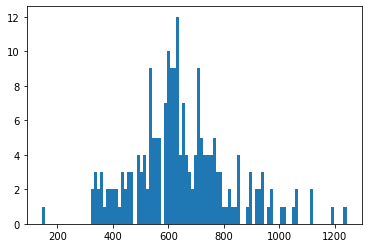

In [96]:
#Looking at the distribution of data
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist([len(i) for i in X],bins=100)
plt.show()

In [97]:
#In order to achieve a confidence interval, select the quartile for the model to train on
import numpy as np
print(np.quantile([len(i) for i in X],0.75))
print(np.quantile([len(i) for i in X],0.95))
print(np.quantile([len(i) for i in X],0.99))

736.0
964.4999999999998
1119.6399999999999


In [98]:
max_len = 1000
from tensorflow.keras.preprocessing import sequence

#Preparing the data for Neural Net (padding the data to be all the same length)
X = sequence.pad_sequences(X, maxlen=max_len)
y = sequence.pad_sequences(y, maxlen=max_len)
X_val = sequence.pad_sequences(X_val, maxlen=max_len)
y_val = sequence.pad_sequences(y_val, maxlen=max_len)

## Storing final processed datasets

In [99]:
%store X
%store y
%store X_val
%store y_val

Stored 'X' (ndarray)
Stored 'y' (ndarray)
Stored 'X_val' (ndarray)
Stored 'y_val' (ndarray)


In [100]:
# X
f = open('X', 'wb')
pickle.dump(X, f)
f.close()
# y
f = open('y', 'wb')
pickle.dump(y, f)
f.close()
# X_val
f = open('X_val', 'wb')
pickle.dump(X_val, f)
f.close()
# y_val
f = open('y_val', 'wb')
pickle.dump(y_val, f)
f.close()

In [101]:
#example of a padded sentence (with leading 0s)
#X[0]

# Bidirectional LSTM
TODO: word_map is also required to run

In [102]:
#Unpickle our
# X
X = pickle.load(open('X', 'rb'))
# y
y = pickle.load(open('y', 'rb'))
#Since we are using 5 fold Cross Validation and have a small training set, this is currently just the training set
# X_val
X_val = pickle.load(open('X_val', 'rb'))
# y_val
y_val = pickle.load(open('y_val', 'rb'))

Test NN to ensure our data is setup properly

# K=Fold Cross Validation with Keras
#https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/

In [103]:
from sklearn.metrics import classification_report

In [ ]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


In [104]:
def kfolds_bidir_weights_model(n,dropout,learning,n_epochs,pat ):
    # K-fold Cross Validation model evaluation
    fold_no = 1
    acc_per_fold =[]
    loss_per_fold=[]
    models =[]
    #classificat_reports=[]
    
    safety = EarlyStopping(monitor='val_loss', patience=pat, restore_best_weights=True)
    
    inv_map = {v: k for k, v in tag_map.items()}
    label_class_weight = {}
    for i in range(len(word_map)):
        if i < 8:
            if inv_map[i]=='O' or inv_map[i]==0: # freuqent class of 'O' or '0'
                label_class_weight[i] = 1.0
            else:
                label_class_weight[i] = 2000.0 # tags we actually care about (ratio for # of 0 tags to true labels)
        else: 
            label_class_weight[i] = 1.0

    kf = KFold(n_splits = n)
    for train, test in kf.split(X, y):

      # Define the model architecture
        model1 = Sequential()
        model1.add(Embedding(len(word_map), 300, input_length=max_len))
        model1.add(Bidirectional(LSTM(256, return_sequences=True)))
        model1.add(Dropout(dropout)) #play with this value 
        model1.add(TimeDistributed(Dense(len(tag_map),activation='softmax')))

        opt =Adam(learning_rate=learning)
        
      # Compile the model
        #change the learning rate
        model1.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


      # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

      # Fit data to model
        history = model1.fit(X[train], y[train], epochs=n_epochs, validation_data=(X[test], y[test]), batch_size=20, 
                             callbacks = [safety], class_weight = label_class_weight) #add weights param

      # Generate generalization metrics
        scores = model1.evaluate(X[test], y[test], verbose=0)
        
        preds = model1.predict(X[test])
        y_test = y[test]
        
        print(f'Score for fold {fold_no}: {model1.metrics_names[0]} of {scores[0]}; {model1.metrics_names[1]} of {scores[1]*100}%')
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])
        models.append(model1)

      # Increase fold number
        fold_no = fold_no + 1
    return (acc_per_fold, loss_per_fold,preds,y_test,models)

# Final Run of LSTM with Weights and Higher Patience

In [105]:
k=5
results = kfolds_bidir_weights_model(k,.35,0.01,100, 5) #100 epochs, 5 stop tolerance
k_avg_acc_per_fold=sum(results[0])/k
k_avg_loss_per_fold=sum(results[1])/k
k_preds=results[2]
k_y_test =results[3]
k_models = results[4]

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
9/9 [==============================] - 23s 2s/step - loss: 1.9446 - accuracy: 0.5953 - val_loss: 0.1437 - val_accuracy: 0.9939
Epoch 2/100
9/9 [==============================] - 20s 2s/step - loss: 0.1313 - accuracy: 0.9938 - val_loss: 0.0980 - val_accuracy: 0.9939
Epoch 3/100
9/9 [==============================] - 19s 2s/step - loss: 0.0944 - accuracy: 0.9940 - val_loss: 0.0920 - val_accuracy: 0.9939
Epoch 4/100
9/9 [==============================] - 18s 2s/step - loss: 0.0822 - accuracy: 0.9940 - val_loss: 0.0698 - val_accuracy: 0.9939
Epoch 5/100
9/9 [==============================] - 19s 2s/step - loss: 0.0557 - accuracy: 0.9937 - val_loss: 0.0512 - val_accuracy: 0.9922
Epoch 6/100
9/9 [==============================] - 23s 3s/step - loss: 0.0371 - accuracy: 0.9927 - val_loss: 0.0438 - val_accuracy: 0.9937
Epoch 7/100
9/9 [==============================] - 17s 2s/step - loss

Epoch 2/100
9/9 [==============================] - 16s 2s/step - loss: 0.0818 - accuracy: 0.9910 - val_loss: 0.0760 - val_accuracy: 0.9903
Epoch 3/100
9/9 [==============================] - 16s 2s/step - loss: 0.0703 - accuracy: 0.9911 - val_loss: 0.0466 - val_accuracy: 0.9931
Epoch 4/100
9/9 [==============================] - 15s 2s/step - loss: 0.0467 - accuracy: 0.9929 - val_loss: 0.0370 - val_accuracy: 0.9941
Epoch 5/100
9/9 [==============================] - 16s 2s/step - loss: 0.0367 - accuracy: 0.9937 - val_loss: 0.0312 - val_accuracy: 0.9941
Epoch 6/100
9/9 [==============================] - 15s 2s/step - loss: 0.0297 - accuracy: 0.9938 - val_loss: 0.0264 - val_accuracy: 0.9941
Epoch 7/100
9/9 [==============================] - 15s 2s/step - loss: 0.0219 - accuracy: 0.9941 - val_loss: 0.0249 - val_accuracy: 0.9944
Epoch 8/100
9/9 [==============================] - 15s 2s/step - loss: 0.0180 - accuracy: 0.9945 - val_loss: 0.0232 - val_accuracy: 0.9950
Epoch 9/100
9/9 [==========

## Saving Final Model Results

In [106]:
#%store results

In [107]:
k_avg_acc_per_fold=sum(results[0])/k
k_avg_loss_per_fold=sum(results[1])/k
k_preds=results[2]
k_y_test =results[3]
k_models = results[4]

In [108]:
# Pickle Model for Usage in other Code
f = open('k_avg_acc_per_fold', 'wb')
pickle.dump(k_avg_acc_per_fold, f)
f.close()
# Pickle Model for Usage in other Code
f = open('k_avg_loss_per_fold', 'wb')
pickle.dump(k_avg_loss_per_fold, f)
f.close()
# Pickle Model for Usage in other Code
f = open('k_preds', 'wb')
pickle.dump(k_preds, f)
f.close()
# Pickle Model for Usage in other Code
f = open('k_y_test', 'wb')
pickle.dump(k_y_test, f)
f.close()

In [109]:
k_models

In [110]:
from keras.models import load_model
for i,model in enumerate(k_models):
    model.save(f'my_model_{i}.h5')  # creates a HDF5 file 'my_model.h5'
    #del model  # deletes the existing model

In [111]:
k_avg_acc_per_fold = pickle.load(open('k_avg_acc_per_fold', 'rb'))
k_avg_loss_per_fold = pickle.load(open('k_avg_loss_per_fold', 'rb'))
k_preds = pickle.load(open('k_preds', 'rb'))
k_y_test = pickle.load(open('k_y_test', 'rb'))

In [112]:
classification_rep = classification_report(
            k_y_test.ravel(), 
            np.argmax(k_preds,
                      axis=2).ravel(), 
            digits=3
        )
print(classification_rep)

              precision    recall  f1-score   support

           0      1.000     1.000     1.000     19585
           1      0.300     0.120     0.171        50
           2      0.500     0.100     0.167        40
           3      0.500     0.025     0.048        40
           4      0.438     0.175     0.250        40
           5      0.692     0.205     0.316        44
           6      0.991     0.999     0.995     22161
           7      0.500     0.200     0.286        40

    accuracy                          0.994     42000
   macro avg      0.615     0.353     0.404     42000
weighted avg      0.992     0.994     0.992     42000



In [113]:
#https://stackoverflow.com/questions/53740577/does-any-one-got-attributeerror-str-object-has-no-attribute-decode-whi
from keras.models import load_model
fname = 'my_model_'+str(1)+'.h5'
model = load_model(fname)

In [114]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 1000, 300)         4752900   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 1000, 512)         1140736   
_________________________________________________________________
dropout_9 (Dropout)          (None, 1000, 512)         0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 1000, 8)           4104      
Total params: 5,897,740
Trainable params: 5,897,740
Non-trainable params: 0
_________________________________________________________________


In [116]:
from keras.models import load_model
k_models_2=[]
for i in range(5):
    fname = 'my_model_'+str(i)+'.h5'
    model = load_model(fname)
    print(f'Loaded {str(i)}th model')
    k_models_2.append(model)
k_models_2

Loaded 0th model
Loaded 1th model
Loaded 2th model
Loaded 3th model
Loaded 4th model


In [1]:
tag_map


NameError: name 'tag_map' is not defined